In [ ]:
# Google Drive 連携
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/AI Programming 2/AI 2 Project/Bird/pythonlibs/images/

/content/drive/MyDrive/Colab Notebooks/AI Programming 2/AI 2 Project/Bird/pythonlibs/images


#前処理

In [ ]:
# 必要ライブラリ・コマンドの導入

# 文字化け防止
!pip install japanize_matplotlib | tail -n 1

!pip install torchviz | tail -n 1

w = !apt install tree
print(w[-2])

Setting up tree (2.0.2-1) ...


In [ ]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [ ]:
# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder


In [ ]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 9

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [ ]:
# GPUチェック（ランタイムの種類をTPUに）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


In [ ]:
def eval_loss(loader, device, net, criterion):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

In [ ]:
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs) # net.forward()と同じ

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [ ]:
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs) # net.forward()と同じ
      predicted = torch.max(outputs,1)[1]

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [ ]:
# 学習ログ解析
def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

In [ ]:
# PyTorch乱数固定用関数
#   評価実験を行う時にランダム要素をなくして（固定して）同じ実験をすることができる
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


#1 データセットの準備

In [ ]:
!unzip Bird.zip | tail -n 1

replace Bird/Test/CP/1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Bird/Test/CP/10.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Bird/Train/SP/99.jpeg   


In [ ]:
!tree Bird

Bird
├── Test
│   ├── CP
│   │   ├── 10.jpeg
│   │   ├── 11.jpeg
│   │   ├── 12.jpeg
│   │   ├── 13.jpeg
│   │   ├── 14.jpeg
│   │   ├── 15.jpeg
│   │   ├── 16.jpeg
│   │   ├── 17.jpeg
│   │   ├── 18.jpeg
│   │   ├── 19.jpeg
│   │   ├── 1.jpeg
│   │   ├── 20.jpeg
│   │   ├── 2.jpeg
│   │   ├── 3.jpeg
│   │   ├── 4.jpeg
│   │   ├── 5.jpeg
│   │   ├── 6.jpeg
│   │   ├── 7.jpeg
│   │   ├── 8.jpeg
│   │   └── 9.jpeg
│   ├── ER
│   │   ├── 10.jpeg
│   │   ├── 11.jpeg
│   │   ├── 12.jpeg
│   │   ├── 13.jpeg
│   │   ├── 14.jpeg
│   │   ├── 15.jpeg
│   │   ├── 16.jpeg
│   │   ├── 17.jpeg
│   │   ├── 18.jpeg
│   │   ├── 19.jpeg
│   │   ├── 1.jpeg
│   │   ├── 20.jpeg
│   │   ├── 2.jpeg
│   │   ├── 3.jpeg
│   │   ├── 4.jpeg
│   │   ├── 5.jpeg
│   │   ├── 6.jpeg
│   │   ├── 7.jpeg
│   │   ├── 8.jpeg
│   │   └── 9.jpeg
│   └── SP
│       ├── 10.jpeg
│       ├── 11.jpeg
│       ├── 12.jpeg
│       ├── 13.jpeg
│       ├── 14.jpeg
│       ├── 15.jpeg
│       ├── 16.jpeg
│       ├── 17.jpeg
│       ├──

In [ ]:
# 訓練データ用: サイズを固定して正規化、追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 検証データ用 : サイズを合わせて、正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [ ]:
# 設定
data_dir = 'Bird'

classes = ['CP', 'ER','SP']  # Here birds name are abbreviated as "CP = Scarlet-chested parrot, ER= Eastern Rosella, SP=Sun Parakeet."

import os
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')

train_data = ImageFolder(train_dir, transform=train_transform)
test_data = ImageFolder(test_dir, transform=test_transform)

In [ ]:
batch_size = 5

# 学習データ（ランダムに学習させる）
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# 検証データ（順序固定で評価する）
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 可視化用
# 学習データ（全体を眺めるため固定）
train_loader2 = DataLoader(train_data, batch_size=40, shuffle=False)
# テスト用データ（テスト画像をランダムに提供）
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=True)

In [ ]:
# データ件数確認

print(f'学習データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

学習データ: 300件
検証データ: 60件


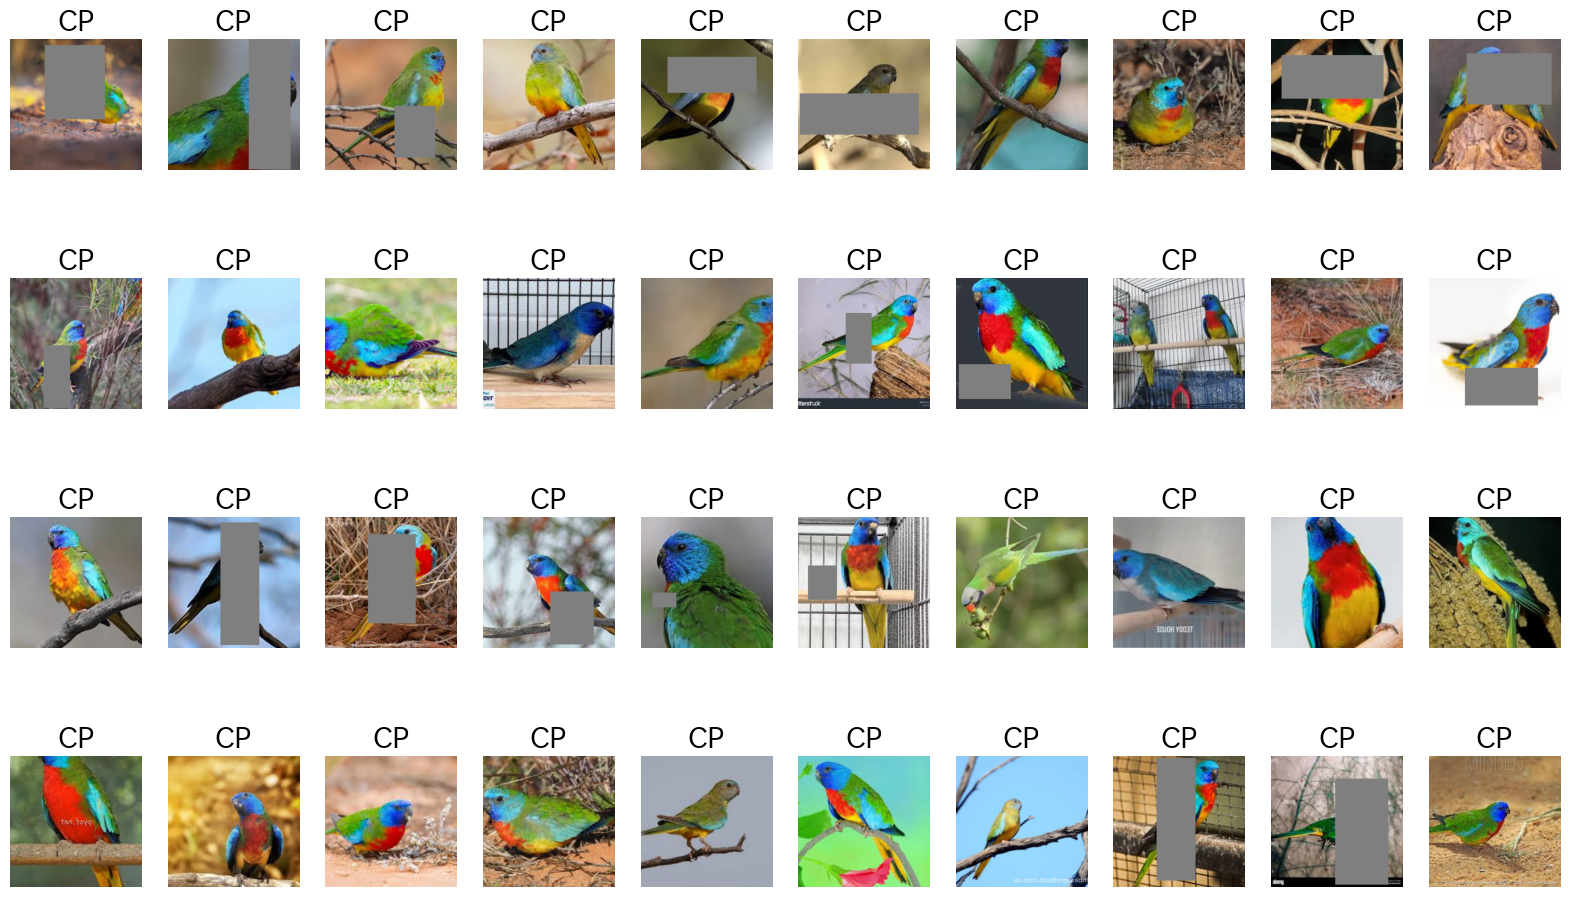

In [ ]:
# 訓練用データ(４0件)
show_images_labels(train_loader2, classes, None, device)

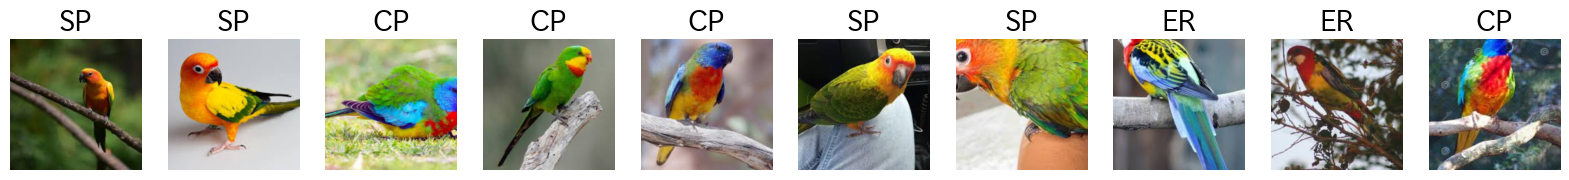

In [ ]:
# 検証用データ(10件)
show_images_labels(test_loader2, classes, None, device)

#2 モデルの学習

#MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(224 * 224  * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, len(classes))
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        self.relu = nn.ReLU()  # ReLU
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.relu(self.fc3(x))

mlp = MLP()
print(mlp)

# GPU対応（CUDA環境があれば計算が速くなる）
if device=="cuda:0":
  mlp.cuda()

MLP(
  (fc1): Linear(in_features=150528, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=3, bias=True)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [ ]:
# 乱数初期化
torch_seed()

# GPUの利用
mlp = mlp.to(device)

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(mlp.parameters(),lr=0.001, momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [ ]:
num_epochs = 50

history = fit(
    mlp,
    optimizer,
    criterion,
    num_epochs,
    train_loader,
    test_loader,
    device,
    history
)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.21452 acc: 0.41000 val_loss: 0.21433, val_acc: 0.41667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.19223 acc: 0.51333 val_loss: 0.20519, val_acc: 0.41667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.17671 acc: 0.57667 val_loss: 0.21029, val_acc: 0.43333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.17655 acc: 0.60000 val_loss: 0.24496, val_acc: 0.45000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.16921 acc: 0.62333 val_loss: 0.20514, val_acc: 0.53333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.13219 acc: 0.72667 val_loss: 0.21165, val_acc: 0.50000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.12919 acc: 0.74667 val_loss: 0.21511, val_acc: 0.55000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.13278 acc: 0.74333 val_loss: 0.25142, val_acc: 0.55000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.11435 acc: 0.77333 val_loss: 0.22664, val_acc: 0.51667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.13814 acc: 0.70000 val_loss: 0.20216, val_acc: 0.51667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.11311 acc: 0.75333 val_loss: 0.19888, val_acc: 0.58333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.10260 acc: 0.78667 val_loss: 0.27950, val_acc: 0.56667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.11055 acc: 0.78667 val_loss: 0.20271, val_acc: 0.41667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.09974 acc: 0.76333 val_loss: 0.24006, val_acc: 0.60000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.08921 acc: 0.81333 val_loss: 0.31019, val_acc: 0.56667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.11789 acc: 0.74667 val_loss: 0.30024, val_acc: 0.56667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.09342 acc: 0.81333 val_loss: 0.18994, val_acc: 0.58333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.07314 acc: 0.82667 val_loss: 0.25421, val_acc: 0.53333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.07334 acc: 0.86000 val_loss: 0.23646, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.08006 acc: 0.82667 val_loss: 0.24706, val_acc: 0.48333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.07167 acc: 0.84000 val_loss: 0.20770, val_acc: 0.55000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.05311 acc: 0.87333 val_loss: 0.38479, val_acc: 0.60000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.06264 acc: 0.88333 val_loss: 0.28546, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.05971 acc: 0.88000 val_loss: 0.28490, val_acc: 0.61667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.04880 acc: 0.90667 val_loss: 0.30152, val_acc: 0.61667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.05623 acc: 0.87667 val_loss: 0.29485, val_acc: 0.58333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.06258 acc: 0.90000 val_loss: 0.23001, val_acc: 0.65000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.06339 acc: 0.89333 val_loss: 0.25491, val_acc: 0.60000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.05827 acc: 0.89333 val_loss: 0.29164, val_acc: 0.60000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.04082 acc: 0.92333 val_loss: 0.35367, val_acc: 0.56667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.02771 acc: 0.92667 val_loss: 0.31161, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.04712 acc: 0.91000 val_loss: 0.31282, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.04660 acc: 0.91333 val_loss: 0.27817, val_acc: 0.56667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.04728 acc: 0.88000 val_loss: 0.36004, val_acc: 0.58333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.02355 acc: 0.94667 val_loss: 0.35358, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.04779 acc: 0.91000 val_loss: 0.33146, val_acc: 0.55000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.04566 acc: 0.89333 val_loss: 0.30580, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.07387 acc: 0.87333 val_loss: 0.33416, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.04770 acc: 0.89667 val_loss: 0.29194, val_acc: 0.61667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.02851 acc: 0.93000 val_loss: 0.34871, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.04328 acc: 0.91333 val_loss: 0.28641, val_acc: 0.61667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.03882 acc: 0.94333 val_loss: 0.44460, val_acc: 0.60000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.05519 acc: 0.91667 val_loss: 0.29079, val_acc: 0.60000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.03030 acc: 0.93000 val_loss: 0.34556, val_acc: 0.56667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.04821 acc: 0.89333 val_loss: 0.26946, val_acc: 0.65000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.03779 acc: 0.92667 val_loss: 0.24886, val_acc: 0.61667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.03477 acc: 0.94000 val_loss: 0.25448, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.03064 acc: 0.92333 val_loss: 0.26979, val_acc: 0.65000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.03015 acc: 0.94333 val_loss: 0.46400, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.03263 acc: 0.94000 val_loss: 0.40658, val_acc: 0.61667


初期状態: 損失: 0.21433 精度: 0.41667
最終状態: 損失: 0.40658 精度: 0.61667


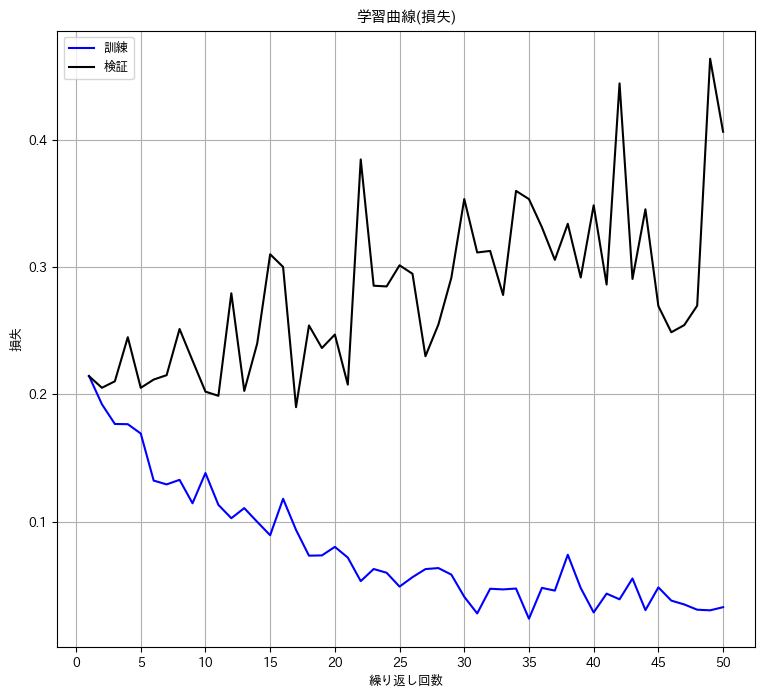

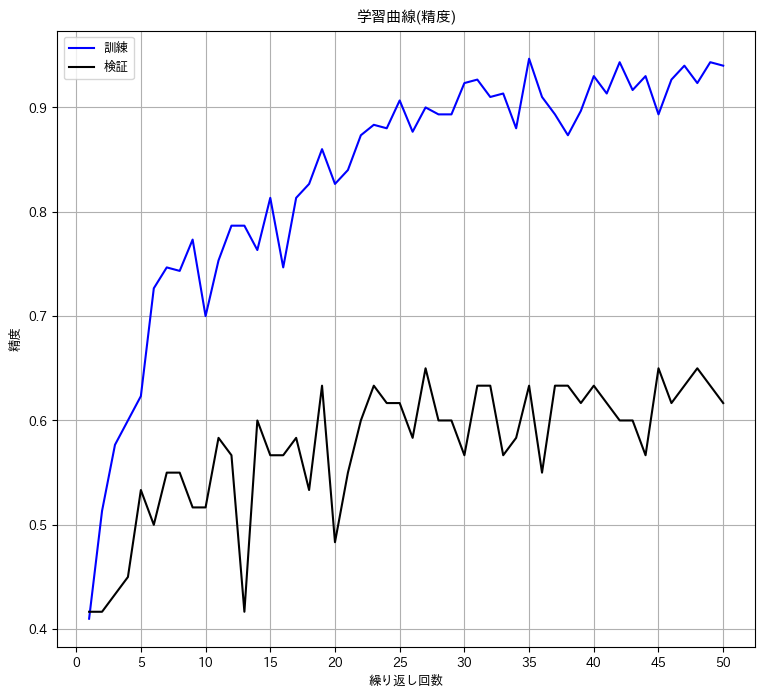

In [ ]:
evaluate_history(history)

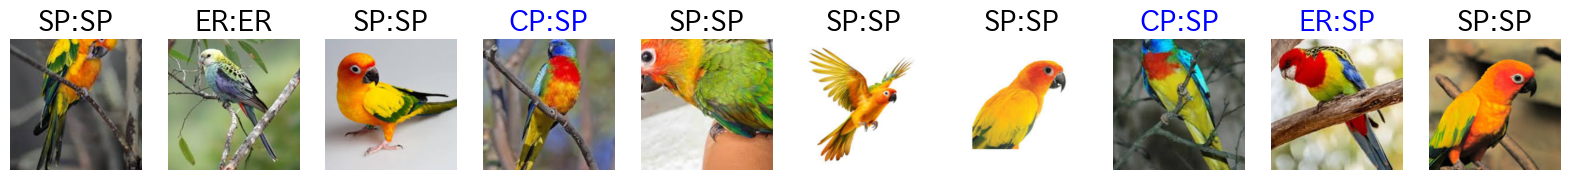

In [ ]:
show_images_labels(test_loader2, classes, mlp, device)

#CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.relu = nn.ReLU()  # ReLU
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, 領域の間隔）
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16*53*53, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, len(classes))

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x)) #1次元化 x = x.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

cnn = CNN()
print(cnn)

# GPU対応（CUDA環境があれば計算が速くなる）
if device=="cuda:0":
  cnn.cuda()

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [ ]:
# 乱数初期化
torch_seed()

# GPUの利用
cnn = cnn.to(device)

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [ ]:
num_epochs = 50

history = fit(
    cnn,
    optimizer,
    criterion,
    num_epochs,
    train_loader,
    test_loader,
    device,
    history
)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.21898 acc: 0.42333 val_loss: 0.21284, val_acc: 0.41667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.19990 acc: 0.48667 val_loss: 0.18857, val_acc: 0.51667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.17284 acc: 0.58000 val_loss: 0.15671, val_acc: 0.63333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.15359 acc: 0.64667 val_loss: 0.17797, val_acc: 0.60000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.16788 acc: 0.66000 val_loss: 0.12885, val_acc: 0.71667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.11722 acc: 0.76333 val_loss: 0.11991, val_acc: 0.76667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.12745 acc: 0.77000 val_loss: 0.14310, val_acc: 0.65000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.09867 acc: 0.85000 val_loss: 0.08415, val_acc: 0.85000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.08513 acc: 0.85000 val_loss: 0.12681, val_acc: 0.75000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.09031 acc: 0.82333 val_loss: 0.07542, val_acc: 0.86667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.09398 acc: 0.82667 val_loss: 0.08301, val_acc: 0.85000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.08017 acc: 0.85333 val_loss: 0.11427, val_acc: 0.76667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.08756 acc: 0.86000 val_loss: 0.07521, val_acc: 0.93333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.05824 acc: 0.90667 val_loss: 0.06257, val_acc: 0.88333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.06017 acc: 0.88333 val_loss: 0.07536, val_acc: 0.86667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.04829 acc: 0.91000 val_loss: 0.07490, val_acc: 0.85000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.06972 acc: 0.87667 val_loss: 0.07247, val_acc: 0.83333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.04275 acc: 0.93000 val_loss: 0.08153, val_acc: 0.83333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.04337 acc: 0.93333 val_loss: 0.10546, val_acc: 0.76667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.04201 acc: 0.93667 val_loss: 0.07443, val_acc: 0.85000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.04423 acc: 0.90333 val_loss: 0.08357, val_acc: 0.86667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.03339 acc: 0.95000 val_loss: 0.06594, val_acc: 0.90000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.03086 acc: 0.94667 val_loss: 0.05210, val_acc: 0.91667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.02145 acc: 0.97000 val_loss: 0.08070, val_acc: 0.90000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.02661 acc: 0.96000 val_loss: 0.06780, val_acc: 0.90000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.02272 acc: 0.97000 val_loss: 0.06332, val_acc: 0.91667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00923 acc: 0.98333 val_loss: 0.07989, val_acc: 0.90000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.02393 acc: 0.97000 val_loss: 0.14966, val_acc: 0.86667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00710 acc: 0.99333 val_loss: 0.11032, val_acc: 0.90000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.01043 acc: 0.98667 val_loss: 0.08723, val_acc: 0.88333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00571 acc: 0.99333 val_loss: 0.07187, val_acc: 0.90000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00922 acc: 0.97667 val_loss: 0.10756, val_acc: 0.86667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.01104 acc: 0.98667 val_loss: 0.07638, val_acc: 0.91667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.01840 acc: 0.97667 val_loss: 0.09344, val_acc: 0.90000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.01462 acc: 0.98000 val_loss: 0.09394, val_acc: 0.86667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.01693 acc: 0.97667 val_loss: 0.08669, val_acc: 0.91667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00753 acc: 0.98667 val_loss: 0.09113, val_acc: 0.91667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00923 acc: 0.99000 val_loss: 0.07738, val_acc: 0.88333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.01287 acc: 0.97000 val_loss: 0.07026, val_acc: 0.91667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00562 acc: 0.99000 val_loss: 0.07091, val_acc: 0.88333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00585 acc: 0.99667 val_loss: 0.11171, val_acc: 0.88333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.01580 acc: 0.97000 val_loss: 0.06048, val_acc: 0.90000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00703 acc: 0.99000 val_loss: 0.07169, val_acc: 0.88333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00364 acc: 0.99667 val_loss: 0.07930, val_acc: 0.88333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00621 acc: 0.98667 val_loss: 0.11341, val_acc: 0.86667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00247 acc: 1.00000 val_loss: 0.07091, val_acc: 0.88333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00580 acc: 0.99000 val_loss: 0.09714, val_acc: 0.86667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.01052 acc: 0.99333 val_loss: 0.05109, val_acc: 0.91667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.01152 acc: 0.99000 val_loss: 0.05136, val_acc: 0.93333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.01304 acc: 0.96667 val_loss: 0.06595, val_acc: 0.91667


初期状態: 損失: 0.21284 精度: 0.41667
最終状態: 損失: 0.06595 精度: 0.91667


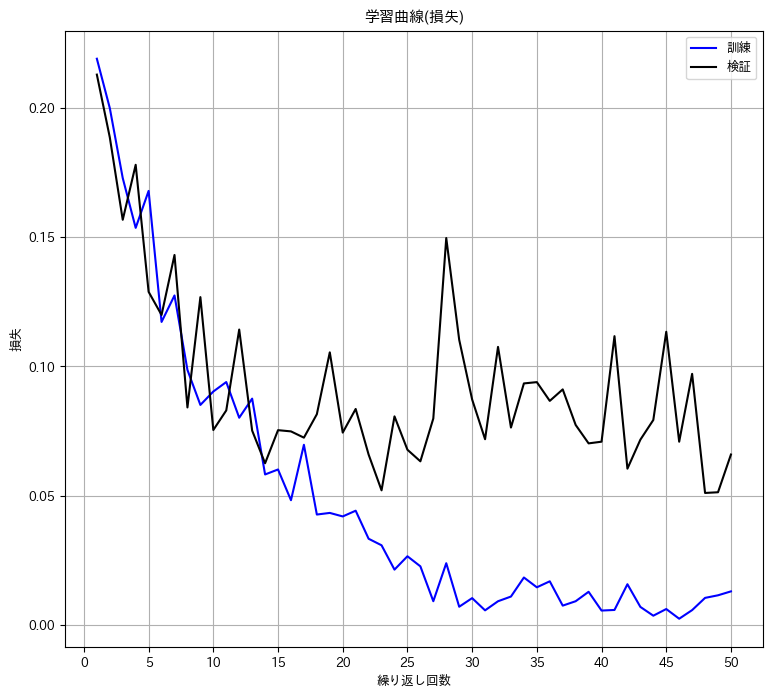

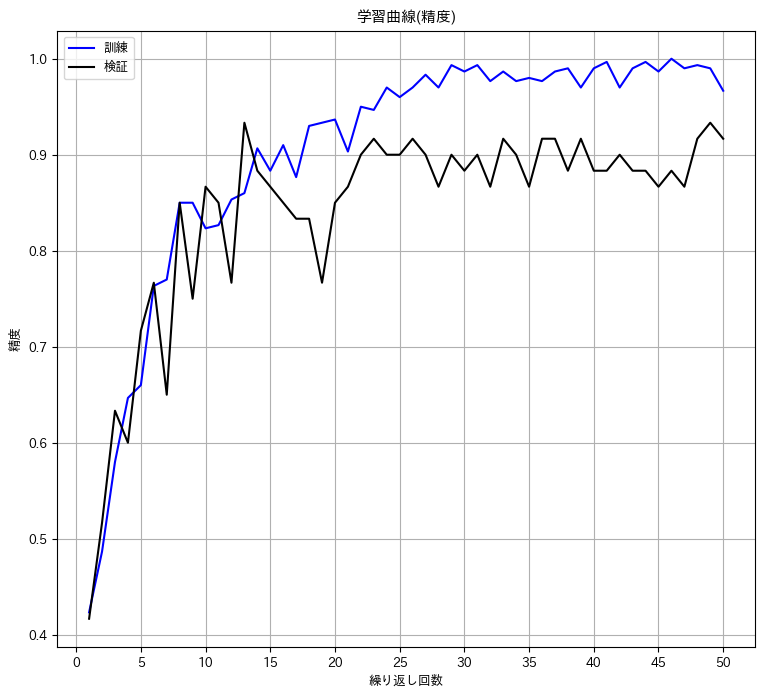

In [ ]:
evaluate_history(history)

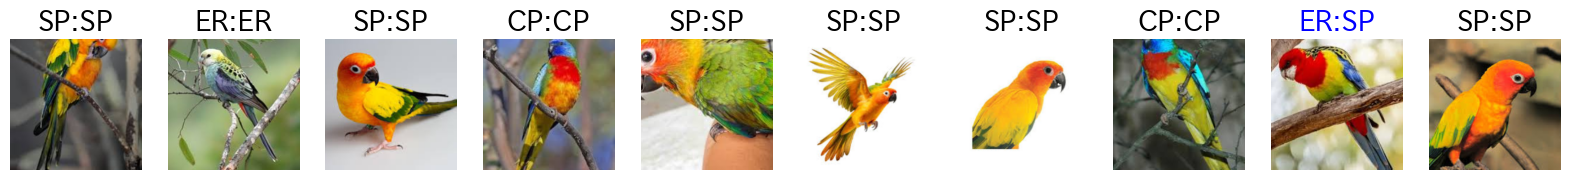

In [ ]:
show_images_labels(test_loader2, classes, cnn, device)

#3 学習済みモデルを活用 (転移学習)

In [ ]:
# 学習済みモデルの読み込み
from torchvision import models

#VGG

In [ ]:
model = models.vgg11_bn(weights=models.VGG11_BN_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:30<00:00, 17.2MB/s]


In [ ]:
# モデルの構造確認
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# 最終ノードの出力を２に変更する
in_features=model.classifier[-1].in_features
model.classifier[-1]=nn.Linear(in_features,3)

In [ ]:
# モデル学習の設定
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

history = np.zeros((0, 5))

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.14103 acc: 0.67667 val_loss: 0.05399, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.06741 acc: 0.88667 val_loss: 0.02598, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.06460 acc: 0.88000 val_loss: 0.01865, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.05619 acc: 0.89000 val_loss: 0.01715, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.05002 acc: 0.89333 val_loss: 0.01223, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.05619 acc: 0.90000 val_loss: 0.01381, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.04703 acc: 0.91333 val_loss: 0.01862, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.05791 acc: 0.88667 val_loss: 0.01141, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.04374 acc: 0.93333 val_loss: 0.01313, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.04823 acc: 0.88000 val_loss: 0.01496, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.04254 acc: 0.93667 val_loss: 0.00936, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.05019 acc: 0.89667 val_loss: 0.01442, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.05058 acc: 0.91333 val_loss: 0.01365, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.04340 acc: 0.91667 val_loss: 0.02713, val_acc: 0.91667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.03967 acc: 0.92000 val_loss: 0.01725, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.04842 acc: 0.90667 val_loss: 0.01441, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.04540 acc: 0.91667 val_loss: 0.02060, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.04443 acc: 0.91000 val_loss: 0.01232, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.04213 acc: 0.91333 val_loss: 0.01006, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.03739 acc: 0.93667 val_loss: 0.01731, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.04575 acc: 0.90333 val_loss: 0.00873, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.04488 acc: 0.91333 val_loss: 0.00861, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.05063 acc: 0.89667 val_loss: 0.01002, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.04610 acc: 0.89333 val_loss: 0.01799, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.03822 acc: 0.93667 val_loss: 0.01289, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.04299 acc: 0.93000 val_loss: 0.01188, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.03837 acc: 0.93333 val_loss: 0.01178, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.04725 acc: 0.91000 val_loss: 0.01173, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.03254 acc: 0.94333 val_loss: 0.00880, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.04316 acc: 0.92667 val_loss: 0.00707, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.02906 acc: 0.94000 val_loss: 0.00603, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.04079 acc: 0.94000 val_loss: 0.00555, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.04226 acc: 0.91333 val_loss: 0.00575, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.02379 acc: 0.94000 val_loss: 0.00683, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.04016 acc: 0.92333 val_loss: 0.00763, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.03193 acc: 0.94333 val_loss: 0.01209, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.04431 acc: 0.91667 val_loss: 0.00833, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.04315 acc: 0.91333 val_loss: 0.00827, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.03739 acc: 0.94000 val_loss: 0.00864, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.04199 acc: 0.93333 val_loss: 0.00676, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.03775 acc: 0.92333 val_loss: 0.00465, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.03167 acc: 0.94000 val_loss: 0.00459, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.03538 acc: 0.93667 val_loss: 0.00655, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.03596 acc: 0.92667 val_loss: 0.00519, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.03706 acc: 0.94000 val_loss: 0.00730, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.03483 acc: 0.93000 val_loss: 0.00685, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.04033 acc: 0.92667 val_loss: 0.00536, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.02442 acc: 0.96000 val_loss: 0.00701, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.03517 acc: 0.93667 val_loss: 0.00687, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.05835 acc: 0.88667 val_loss: 0.00724, val_acc: 1.00000
初期状態: 損失: 0.05399 精度: 0.95000
最終状態: 損失: 0.00724 精度: 1.00000


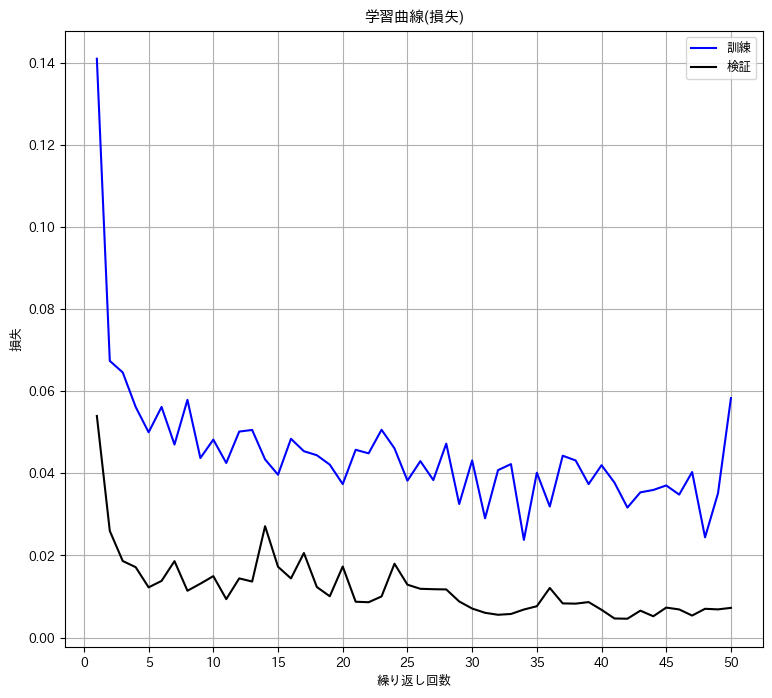

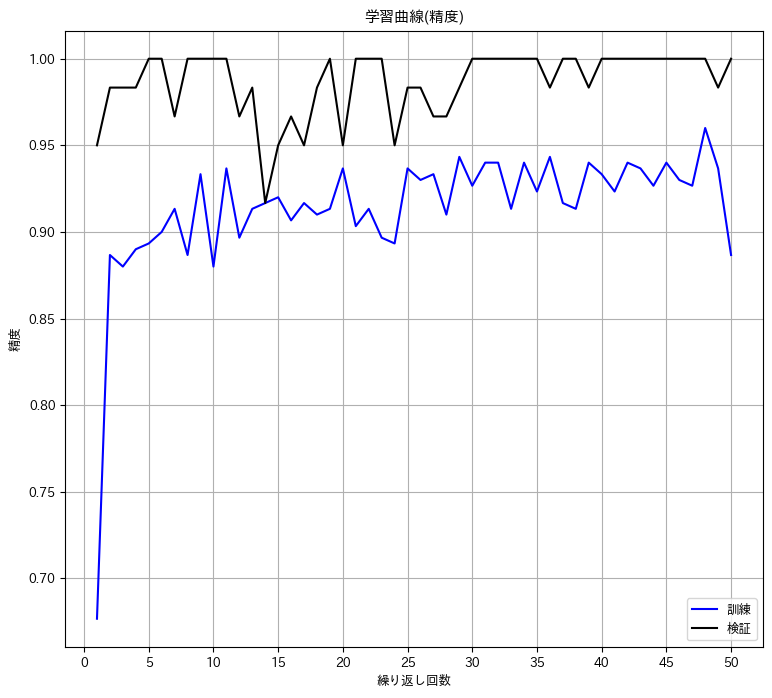

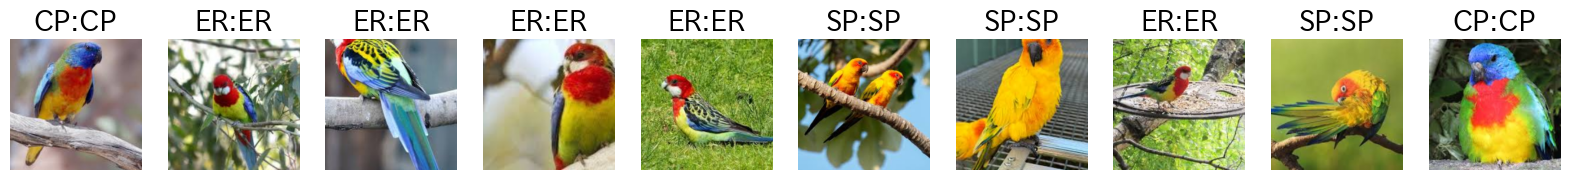

In [ ]:
# 学習の実行
num_epochs = 50
history = fit(
    model,
    optimizer,
    criterion,
    num_epochs,
    train_loader,
    test_loader,
    device,
    history
)

# 結果表示
evaluate_history(history)

# テストデータの分類結果表示
show_images_labels(test_loader2, classes, model, device)

#ResNet

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


In [ ]:
# モデルの構造確認
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# モデルの最終層のノード数を変更
in_features=model.fc.in_features
model.fc=nn.Linear(in_features,3)


In [ ]:
# モデル学習の設定
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

history = np.zeros((0, 5))

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.21061 acc: 0.48000 val_loss: 0.18770, val_acc: 0.85000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.17625 acc: 0.78333 val_loss: 0.16155, val_acc: 0.90000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.15324 acc: 0.83667 val_loss: 0.13850, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.13321 acc: 0.87333 val_loss: 0.12291, val_acc: 0.93333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.12291 acc: 0.86667 val_loss: 0.11155, val_acc: 0.93333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.10729 acc: 0.91000 val_loss: 0.10333, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.10427 acc: 0.90667 val_loss: 0.09881, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.09634 acc: 0.89667 val_loss: 0.08536, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.08973 acc: 0.91333 val_loss: 0.08622, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.08794 acc: 0.91333 val_loss: 0.08553, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.08122 acc: 0.91667 val_loss: 0.07008, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.07814 acc: 0.91667 val_loss: 0.06949, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.07782 acc: 0.91667 val_loss: 0.08219, val_acc: 0.93333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.07562 acc: 0.93667 val_loss: 0.07023, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.06428 acc: 0.94667 val_loss: 0.06492, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.06878 acc: 0.91000 val_loss: 0.06704, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.06855 acc: 0.92667 val_loss: 0.05918, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.05843 acc: 0.95333 val_loss: 0.05486, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.06245 acc: 0.94667 val_loss: 0.05957, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.06788 acc: 0.91667 val_loss: 0.05143, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.05936 acc: 0.94667 val_loss: 0.05652, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.05626 acc: 0.93000 val_loss: 0.04998, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.06099 acc: 0.93667 val_loss: 0.04931, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.05367 acc: 0.95333 val_loss: 0.04466, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.04872 acc: 0.96667 val_loss: 0.04288, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.06651 acc: 0.91333 val_loss: 0.04868, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.05143 acc: 0.94667 val_loss: 0.04408, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.05086 acc: 0.96333 val_loss: 0.04798, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.04942 acc: 0.94333 val_loss: 0.04131, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.06515 acc: 0.93333 val_loss: 0.04271, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.04619 acc: 0.96000 val_loss: 0.04633, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.04802 acc: 0.94333 val_loss: 0.04263, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.04331 acc: 0.96333 val_loss: 0.04337, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.04584 acc: 0.95333 val_loss: 0.04498, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.05064 acc: 0.94000 val_loss: 0.04024, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.04665 acc: 0.95333 val_loss: 0.03655, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.04827 acc: 0.95333 val_loss: 0.04580, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.04393 acc: 0.96333 val_loss: 0.03947, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.04580 acc: 0.94000 val_loss: 0.03735, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.04703 acc: 0.93333 val_loss: 0.04172, val_acc: 0.95000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.03778 acc: 0.97667 val_loss: 0.03621, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.03804 acc: 0.98333 val_loss: 0.03537, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.03896 acc: 0.96000 val_loss: 0.03329, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.03623 acc: 0.96333 val_loss: 0.03408, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.04450 acc: 0.96333 val_loss: 0.03211, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.04007 acc: 0.95667 val_loss: 0.03126, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.03592 acc: 0.96667 val_loss: 0.03165, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.04109 acc: 0.95333 val_loss: 0.02996, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.03879 acc: 0.96333 val_loss: 0.03488, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.03548 acc: 0.96667 val_loss: 0.03814, val_acc: 0.96667
初期状態: 損失: 0.18770 精度: 0.85000
最終状態: 損失: 0.03814 精度: 0.96667


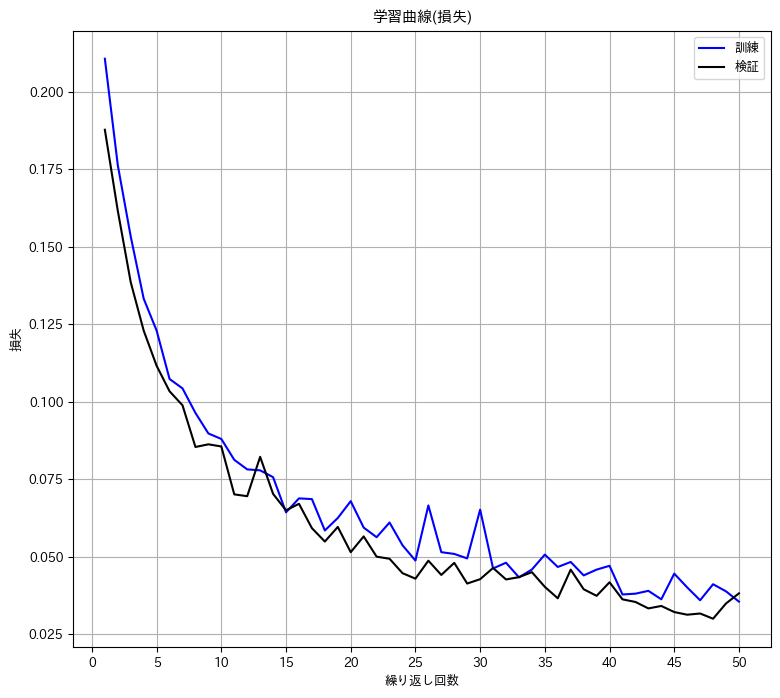

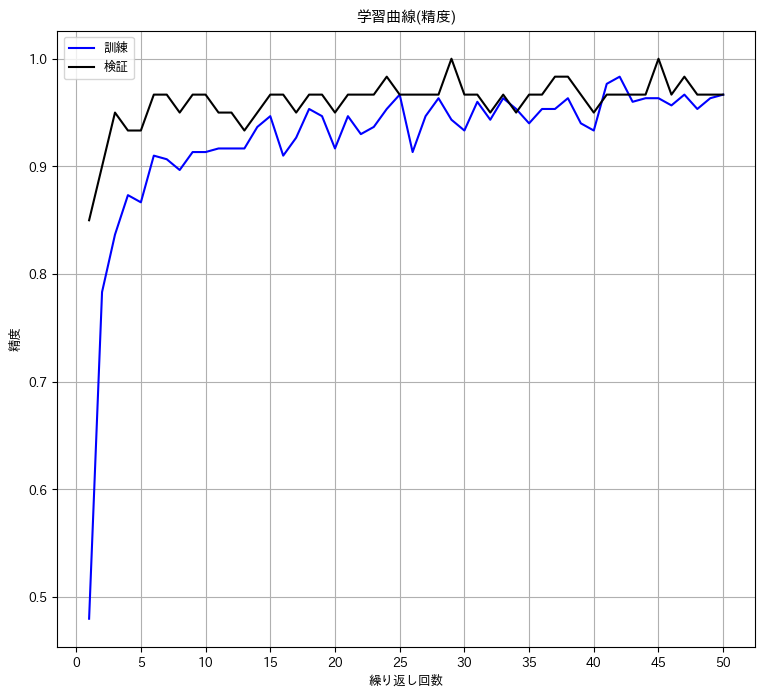

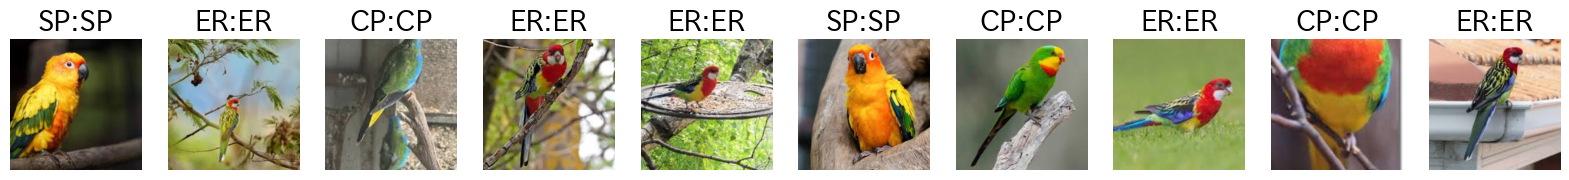

In [ ]:
# 学習の実行
num_epochs = 50
history = fit(
    model,
    optimizer,
    criterion,
    num_epochs,
    train_loader,
    test_loader,
    device,
    history
)

# 結果表示
evaluate_history(history)

# テストデータの分類結果表示
show_images_labels(test_loader2, classes, model, device)

#ViT (Transformer based model)

In [ ]:
model=models.vit_l_16(weights=models.ViT_L_16_Weights)
for param in model.parameters():
    param.requires_grad = False

model

Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [00:12<00:00, 101MB/s] 


VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

In [ ]:
# モデルの最終層のノード数を変更
in_features=model.heads[0].in_features
model.heads[0]=nn.Linear(in_features,3)


In [ ]:
# モデル学習の設定
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.heads[0].parameters(), lr=0.001, momentum=0.9)

history = np.zeros((0, 5))

In [ ]:
# 学習の実行
num_epochs = 50
history = fit(
    model,
    optimizer,
    criterion,
    num_epochs,
    train_loader,
    test_loader,
    device,
    history
)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.12803 acc: 0.75000 val_loss: 0.06904, val_acc: 0.93333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.05093 acc: 0.95333 val_loss: 0.04784, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.03364 acc: 0.97333 val_loss: 0.04066, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.02722 acc: 0.97667 val_loss: 0.03746, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.02189 acc: 0.97667 val_loss: 0.03407, val_acc: 0.96667


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.02015 acc: 0.98333 val_loss: 0.03116, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01447 acc: 1.00000 val_loss: 0.02735, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01337 acc: 0.99333 val_loss: 0.02532, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01754 acc: 0.98333 val_loss: 0.02367, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01241 acc: 0.99667 val_loss: 0.02338, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01232 acc: 0.99333 val_loss: 0.02208, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01164 acc: 0.99333 val_loss: 0.02121, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01359 acc: 0.99000 val_loss: 0.02056, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.01196 acc: 0.99000 val_loss: 0.01872, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00984 acc: 0.99667 val_loss: 0.01811, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00956 acc: 0.99667 val_loss: 0.01737, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00768 acc: 1.00000 val_loss: 0.01653, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.01115 acc: 0.99333 val_loss: 0.01658, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00702 acc: 1.00000 val_loss: 0.01596, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00868 acc: 0.99667 val_loss: 0.01586, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00799 acc: 0.99667 val_loss: 0.01523, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00689 acc: 0.99667 val_loss: 0.01480, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00861 acc: 0.99667 val_loss: 0.01526, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00565 acc: 1.00000 val_loss: 0.01494, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00772 acc: 0.99000 val_loss: 0.01537, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00645 acc: 0.99667 val_loss: 0.01379, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00722 acc: 0.99000 val_loss: 0.01336, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00825 acc: 0.99333 val_loss: 0.01305, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00510 acc: 1.00000 val_loss: 0.01357, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00574 acc: 0.99333 val_loss: 0.01294, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00762 acc: 0.99000 val_loss: 0.01267, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00491 acc: 1.00000 val_loss: 0.01314, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00602 acc: 0.99333 val_loss: 0.01214, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00756 acc: 0.99000 val_loss: 0.01153, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00786 acc: 0.99667 val_loss: 0.01188, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00618 acc: 0.99667 val_loss: 0.01140, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00517 acc: 1.00000 val_loss: 0.01135, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00501 acc: 1.00000 val_loss: 0.01095, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00545 acc: 0.99667 val_loss: 0.01045, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00489 acc: 1.00000 val_loss: 0.01042, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00643 acc: 0.99667 val_loss: 0.00985, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00553 acc: 0.99333 val_loss: 0.01005, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00427 acc: 0.99667 val_loss: 0.00960, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00384 acc: 0.99667 val_loss: 0.00966, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00411 acc: 0.99667 val_loss: 0.00956, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00412 acc: 1.00000 val_loss: 0.00943, val_acc: 0.98333


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00313 acc: 1.00000 val_loss: 0.00916, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00382 acc: 0.99667 val_loss: 0.00942, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00431 acc: 0.99667 val_loss: 0.00999, val_acc: 1.00000


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00277 acc: 1.00000 val_loss: 0.00946, val_acc: 0.98333


初期状態: 損失: 0.06904 精度: 0.93333
最終状態: 損失: 0.00946 精度: 0.98333


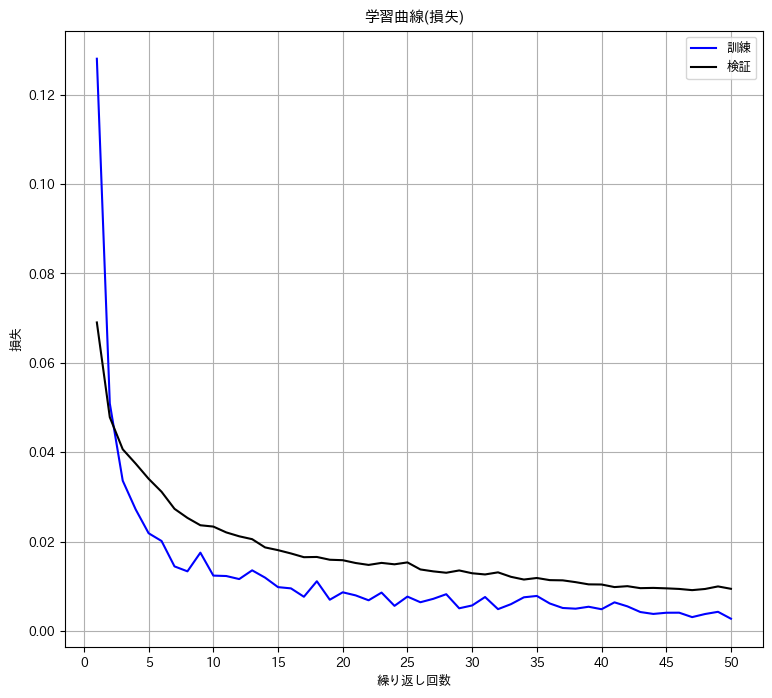

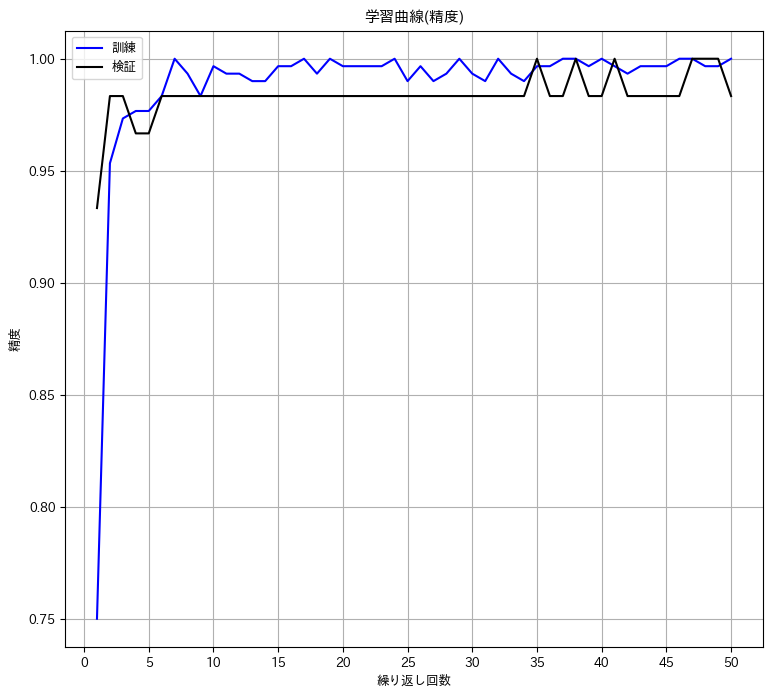

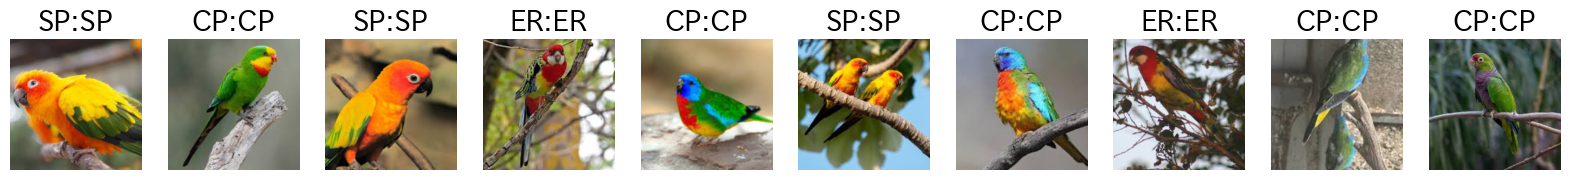

In [ ]:


# 結果表示
evaluate_history(history)

# テストデータの分類結果表示
show_images_labels(test_loader2, classes, model, device)

In [ ]:
%%writefile bird-classification.py

import streamlit as st
import matplotlib.pyplot as plt
from PIL import Image
from mymodel import predict

#st.set_option("deprecation.showfileUploaderEncoding", False)

st.sidebar.title("画像認識アプリ")
st.sidebar.write("オリジナルの画像認識モデルを使って何の画像かを判定します。")

st.sidebar.write("")

img_source = st.sidebar.radio("画像のソースを選択してください。",
                              ("画像をアップロード", "カメラで撮影"))
if img_source == "画像をアップロード":
    img_file = st.sidebar.file_uploader("画像を選択してください。", type=["png", "jpg", "jpeg"])
elif img_source == "カメラで撮影":
    img_file = st.camera_input("カメラで撮影")

if img_file is not None:
    with st.spinner("推定中..."):
        img = Image.open(img_file)
        st.image(img, caption="対象の画像", width=480)
        st.write("")

        # 予測
        results = predict(img)

        # 結果の表示
        st.subheader("判定結果")
        n_top = 3  # 確率が高い順に3位まで返す
        for result in results[:n_top]:
            st.write(str(round(result[2]*100, 2)) + "%の確率で" + result[0] + "です。")

        # 円グラフの表示
        pie_labels = [result[1] for result in results[:n_top]]
        pie_labels.append("others")  # その他
        pie_probs = [result[2] for result in results[:n_top]]
        pie_probs.append(sum([result[2] for result in results[n_top:]]))  # その他
        fig, ax = plt.subplots()
        wedgeprops={"width":0.3, "edgecolor":"white"}
        textprops = {"fontsize":6}
        ax.pie(pie_probs, labels=pie_labels, counterclock=False, startangle=90,
               textprops=textprops, autopct="%.2f", wedgeprops=wedgeprops)  # 円グラフ
        st.pyplot(fig)

st.sidebar.write("")
st.sidebar.write("")


st.sidebar.caption("""
このアプリは、「Fashion-MNIST」を訓練データとして使っています。\n
Copyright (c) 2017 Zalando SE\n
Released under the MIT license\n
https://github.com/zalandoresearch/fashion-mnist#license
""")

Overwriting bird-classification.py


In [ ]:
!streamlit run bird-classification.py & sleep 3 && npx localtunnel --port 8501

/bin/bash: line 1: streamlit: command not found
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴your url is: https://good-comics-design.loca.lt
y
/root/.npm/_npx/75ac80b86e83d4a2/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:14629 (check your firewall settings)
    at Socket.<anonymous> (/root/.npm/_npx/75ac80b86e83d4a2/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at Socket.emit (node:events:524:28)
    at emitErrorNT (node:internal/streams/destroy:169:8)
    at emitErrorCloseNT (node:internal/streams/destroy:128:3)
    at process.processTicksAndRejections (node:internal/process/task_queues:82:21)

Node.js v20.19.0
⠙npm notice
npm notice New major version of npm available! 10.8.2 -> 11.5.2
npm notice Changelog: https://github.com/npm/cli/releases/tag/v11.5.2
npm notice To update run: npm install -g npm@11.5.2
npm notice
⠙

In [ ]:
!pip install streamlit==1.8.1 --quiet
!pip install pyngrok==4.1.1 --quiet

In [ ]:
!pip install protobuf==3.20;x --quiet
import streamlit as st
from pyngrok import ngrok

/bin/bash: line 1: x: command not found


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
2025-08-06 09:41:43.492 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


ModuleNotFoundError: No module named 'altair.vegalite.v4'